# Intermediate machine learning Kaggle

## Intro

In [106]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_full = pd.read_csv('../data/intermediate_train.csv', index_col='Id')
X_test_full = pd.read_csv('../data/intermediate_test.csv', index_col='Id')

# Obtain target and predictors
y = X_full.SalePrice
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_test_full[features].copy()

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [107]:
X_train.head()

,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd
Id,,,,,,,
619,11694,2007,1828,0,2,3,9
871,6600,1962,894,0,1,2,5
93,13360,1921,964,0,1,2,5
818,13265,2002,1689,0,2,3,7
303,13704,2001,1541,0,2,3,6


In [108]:
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

In [109]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 24015
Model 2 MAE: 23740
Model 3 MAE: 23528
Model 4 MAE: 23996
Model 5 MAE: 23706


## Missing values

### Example

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/melb_data.csv')

# Select target
y = data.Price

# To keep things simple, we'll use only numerical predictors
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

FileNotFoundError: [Errno 2] No such file or directory: 'data/melb_data.csv'

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

Dropping columns with missing values

In [14]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
183550.22137772635


Using simple imputer on columns with missing values

In [15]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 2 (Imputation):
178166.46269899711


Using extension to imputation on columns with missing values

In [17]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
178927.503183954


In [20]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(10864, 12)
Car               49
BuildingArea    5156
YearBuilt       4307
dtype: int64


### Exercise

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_full = pd.read_csv('../data/intermediate_train.csv', index_col='Id')
X_test_full = pd.read_csv('../data/intermediate_test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [3]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,774,0,108,0,0,260,0,0,7,2007
871,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,308,0,0,0,0,0,0,0,8,2009
93,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,432,0,0,44,0,0,0,0,8,2009
818,20,NaN,13265,8,5,2002,2002,148.0,1218,0,...,857,150,59,0,0,0,0,0,7,2008
303,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,843,468,81,0,0,0,0,0,1,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,60,82.0,9430,8,5,1999,1999,673.0,1163,0,...,856,0,128,0,0,180,0,0,7,2009
836,20,60.0,9600,4,7,1950,1995,0.0,442,0,...,436,290,0,0,0,0,0,0,2,2010
1217,90,68.0,8930,6,5,1978,1978,0.0,0,0,...,539,0,0,0,0,0,0,0,4,2010


In [4]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1168, 36)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [5]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1168.000000,956.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1162.000000,1168.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.605308,69.614017,10589.672945,6.086473,5.572774,1970.890411,1984.692637,103.481067,439.890411,45.571918,...,473.632705,94.498288,48.044521,23.022260,3.218322,14.528253,2.118151,50.936644,6.301370,2007.819349
std,42.172322,22.946069,10704.180793,1.367472,1.116908,30.407486,20.684612,182.676225,435.106803,156.229962,...,209.442320,127.312017,68.619199,63.153093,27.916593,54.009608,36.482294,550.380636,2.725977,1.335971
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7589.500000,5.000000,5.000000,1953.750000,1966.000000,0.000000,0.000000,0.000000,...,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9512.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,379.500000,0.000000,...,477.500000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,167.750000,716.000000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1120.000000,...,1390.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

#### Dropping columns with missing values

In [27]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

In [28]:
print("MAE (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE (Drop columns with missing values):
17837.82570776256


#### Using simple imputer on columns with missing values

In [29]:
from sklearn.impute import SimpleImputer

# Fill in the lines below: imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

In [30]:
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Imputation):
18062.894611872147


#### Using YearBuilt in GarageYrBlt when missing and dropping other missing columns

In [14]:
copy_X_train = X_train

copy_X_valid = X_valid

copy_X_train['GarageYrBlt'] = copy_X_train['GarageYrBlt'].fillna(copy_X_train['YearBuilt'])

copy_X_valid['GarageYrBlt'] = copy_X_valid['GarageYrBlt'].fillna(copy_X_valid['YearBuilt'])


In [15]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_replaced_X_train = copy_X_train.drop(cols_with_missing, axis=1)
reduced_replaced_X_valid = copy_X_valid.drop(cols_with_missing, axis=1)

In [16]:
print("MAE (Replacing missing GarageYrBlt with YearBuilt):")
print(score_dataset(reduced_replaced_X_train, reduced_replaced_X_valid, y_train, y_valid))

MAE (Replacing missing GarageYrBlt with YearBuilt):
17763.675764840184


#### Handling missing LotFrontage values with simple imputer and replacing GarageYrBlt with YearBuilt

In [30]:
from sklearn.impute import SimpleImputer

copy_X_train = X_train

copy_X_valid = X_valid

copy_X_train['GarageYrBlt'] = copy_X_train['GarageYrBlt'].fillna(copy_X_train['YearBuilt'])

copy_X_valid['GarageYrBlt'] = copy_X_valid['GarageYrBlt'].fillna(copy_X_valid['YearBuilt'])

# Fill in the lines below: imputation
my_imputer = SimpleImputer(strategy='median')
imputed_copied_X_train = pd.DataFrame(my_imputer.fit_transform(copy_X_train))
imputed_copied_X_valid = pd.DataFrame(my_imputer.transform(copy_X_valid))

# Fill in the lines below: imputation removed column names; put them back
imputed_copied_X_train.columns = X_train.columns
imputed_copied_X_valid.columns = X_valid.columns

LotFrontage    212
MasVnrArea       6
dtype: int64
Series([], dtype: int64)


#### Handling missing values in LotFrontage with Linear Regression

In [71]:
X_train.describe()['LotFrontage']

count    956.000000
mean      69.614017
std       22.946069
min       21.000000
25%       59.000000
50%       69.000000
75%       80.000000
max      313.000000
Name: LotFrontage, dtype: float64

In [72]:
lotfrontage_area = X_train[X_train['LotFrontage'].notna()][['LotArea','LotFrontage']]
lotfrontage_area

,LotArea,LotFrontage
Id,,
619,11694,90.0
871,6600,60.0
93,13360,80.0
303,13704,118.0
1455,7500,62.0
...,...,...
278,19138,140.0
764,9430,82.0
836,9600,60.0


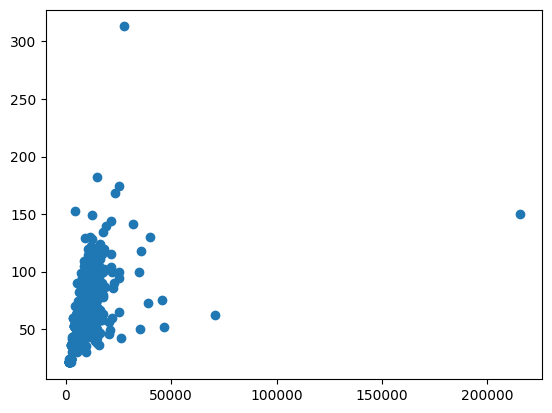

In [73]:
import matplotlib.pyplot as plt

plt.scatter(lotfrontage_area.LotArea, lotfrontage_area.LotFrontage)
 
# To show the plot
plt.show()

In [74]:
lotfrontage_area_X = lotfrontage_area[['LotArea']]
lotfrontage_area_y = lotfrontage_area['LotFrontage']

In [75]:
lotfrontage_area_unknowns_X_train = X_train[X_train['LotFrontage'].isna()][['LotArea']]
lotfrontage_area_unknowns_X_valid = X_valid[X_valid['LotFrontage'].isna()][['LotArea']]

In [76]:
# Break off validation set from training data
X_lotfrontage_area_train, X_lotfrontage_area_valid, y_lotfrontage_area_train, y_lotfrontage_area_valid = train_test_split(lotfrontage_area_X, 
                                                                                                                          lotfrontage_area_y, 
                                                                                                                          train_size=0.8, 
                                                                                                                          test_size=0.2,
                                                                                                                          random_state=322)

In [86]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X_lotfrontage_area_train, y_lotfrontage_area_train)

predicted_values_reg = reg.predict(X_lotfrontage_area_valid)

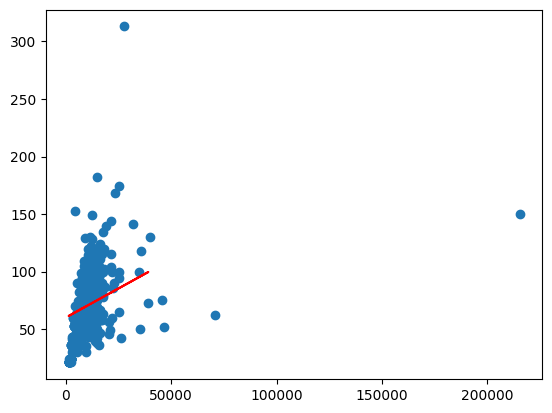

In [87]:
plt.scatter(lotfrontage_area.LotArea, lotfrontage_area.LotFrontage)
plt.plot(X_lotfrontage_area_valid, predicted_values_reg, color='red')
# To show the plot
plt.show()

In [88]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(y_lotfrontage_area_valid, predicted_values_reg)
print(f'Mean Absolute Error: {mae}')

r_squared = r2_score(y_lotfrontage_area_valid, predicted_values_reg)
print(f'R-squared: {r_squared}')

mse = mean_squared_error(y_lotfrontage_area_valid, predicted_values_reg)
rmse = mean_squared_error(y_lotfrontage_area_valid, predicted_values_reg, squared=False)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 14.254330297043246
R-squared: 0.16835817202529768
Mean Squared Error: 330.8958992683021
Root Mean Squared Error: 18.190544226831207


In [80]:
predicted_values_X_train = reg.predict(lotfrontage_area_unknowns_X_train)
predicted_values_X_valid = reg.predict(lotfrontage_area_unknowns_X_valid)

In [81]:
from sklearn.impute import SimpleImputer

# Fill missing values in the dataframe with Linear Regression for LotFrontage based on LotArea
X_train.loc[X_train['LotFrontage'].isnull(), 'LotFrontage'] = predicted_values_X_train
X_valid.loc[X_valid['LotFrontage'].isnull(), 'LotFrontage'] = predicted_values_X_valid

# Replacing GarageYrBlt and imputing any other NaNs
copy_X_train = X_train

copy_X_valid = X_valid

copy_X_train['GarageYrBlt'] = copy_X_train['GarageYrBlt'].fillna(copy_X_train['YearBuilt'])

copy_X_valid['GarageYrBlt'] = copy_X_valid['GarageYrBlt'].fillna(copy_X_valid['YearBuilt'])


# Fill in the lines below: imputation
my_imputer = SimpleImputer()
replaced_X_train = pd.DataFrame(my_imputer.fit_transform(copy_X_train))
replaced_X_valid = pd.DataFrame(my_imputer.transform(copy_X_valid))

# Fill in the lines below: imputation removed column names; put them back
replaced_X_train.columns = copy_X_train.columns
replaced_X_valid.columns = copy_X_valid.columns

MasVnrArea    6
dtype: int64


In [82]:
print("MAE (Replacing missing GarageYrBlt with YearBuilt, Linear Regression for LotFrontage based on LotArea, and imputing other missing NaNs):")
print(score_dataset(replaced_X_train, replaced_X_valid, y_train, y_valid))

MAE (Replacing missing GarageYrBlt with YearBuilt, Linear Regression for LotFrontage based on LotArea, and imputing other missing NaNs):
17951.66196347032


## Categorical values

A categorical variable takes only a limited number of values.

Consider a survey that asks how often you eat breakfast and provides four options: "Never", "Rarely", "Most days", or "Every day". In this case, the data is categorical, because responses fall into a fixed set of categories.
If people responded to a survey about which what brand of car they owned, the responses would fall into categories like "Honda", "Toyota", and "Ford". In this case, the data is also categorical.

### Three approaches

1) Drop Categorical Variables
The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.

2) Ordinal Encoding
Ordinal encoding assigns each unique value to a different integer.

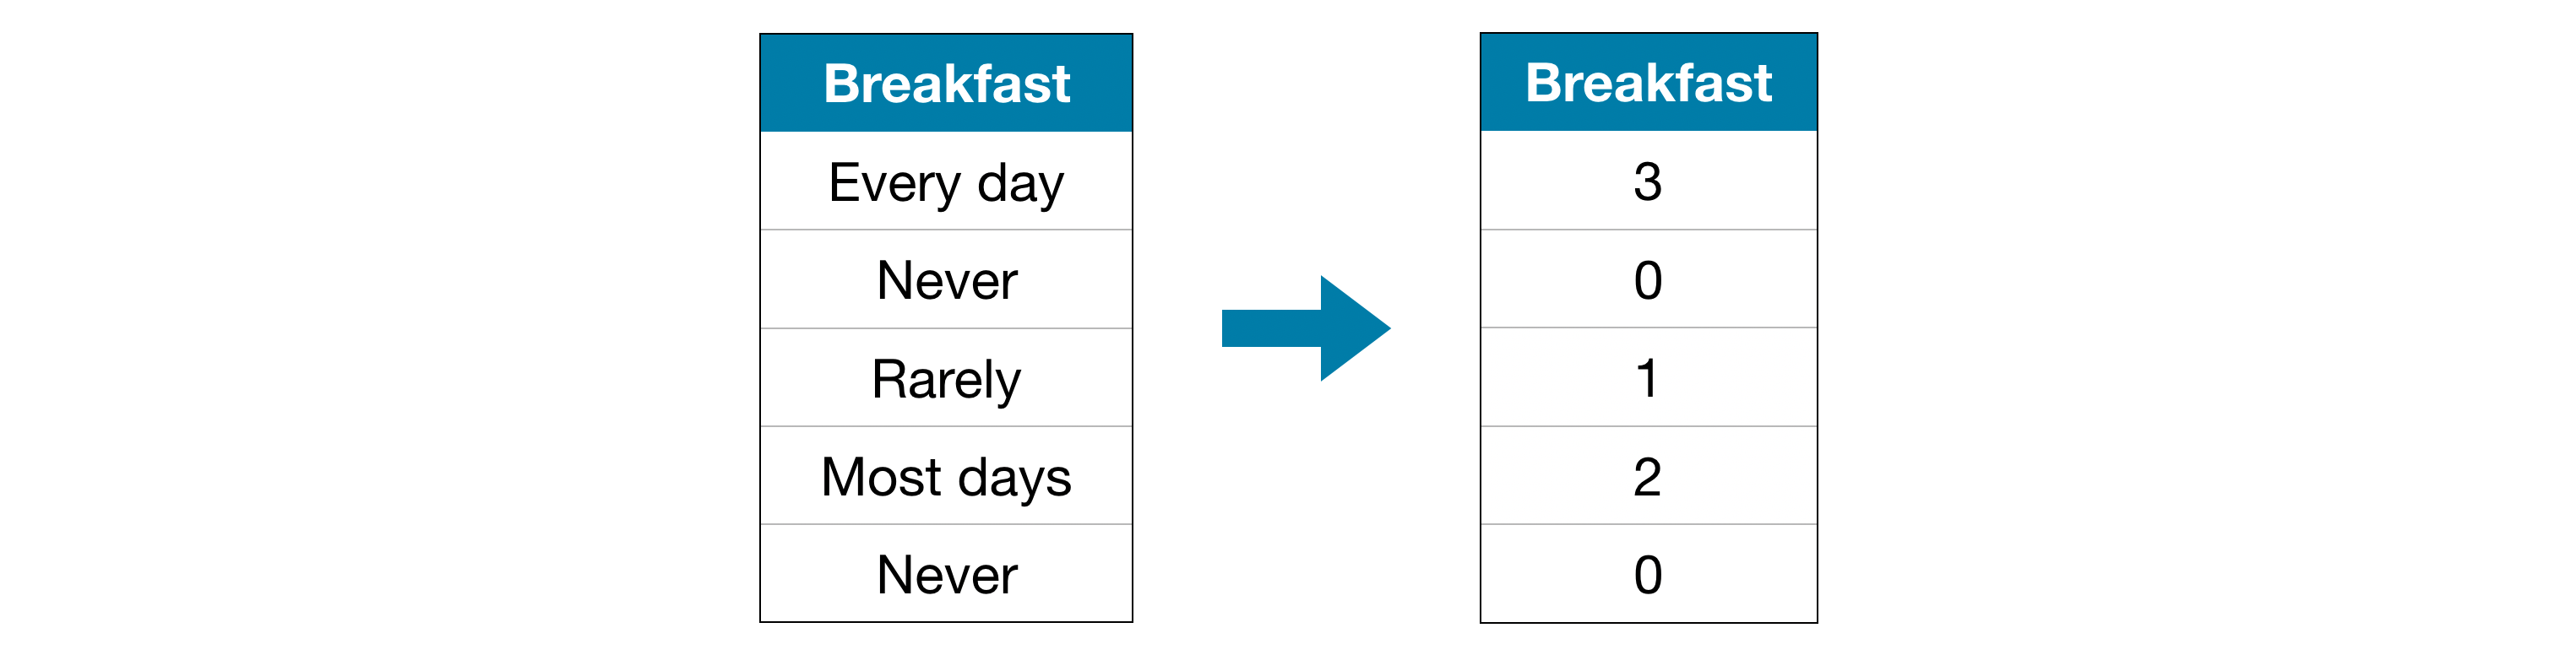

This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

This assumption makes sense in this example, because there is an indisputable ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as ordinal variables. For tree-based models (like decision trees and random forests), you can expect ordinal encoding to work well with ordinal variables.

3) One-Hot Encoding¶
One-hot encoding creates new columns indicating the presence (or absence) of each possible value in the original data. To understand this, we'll work through an example.

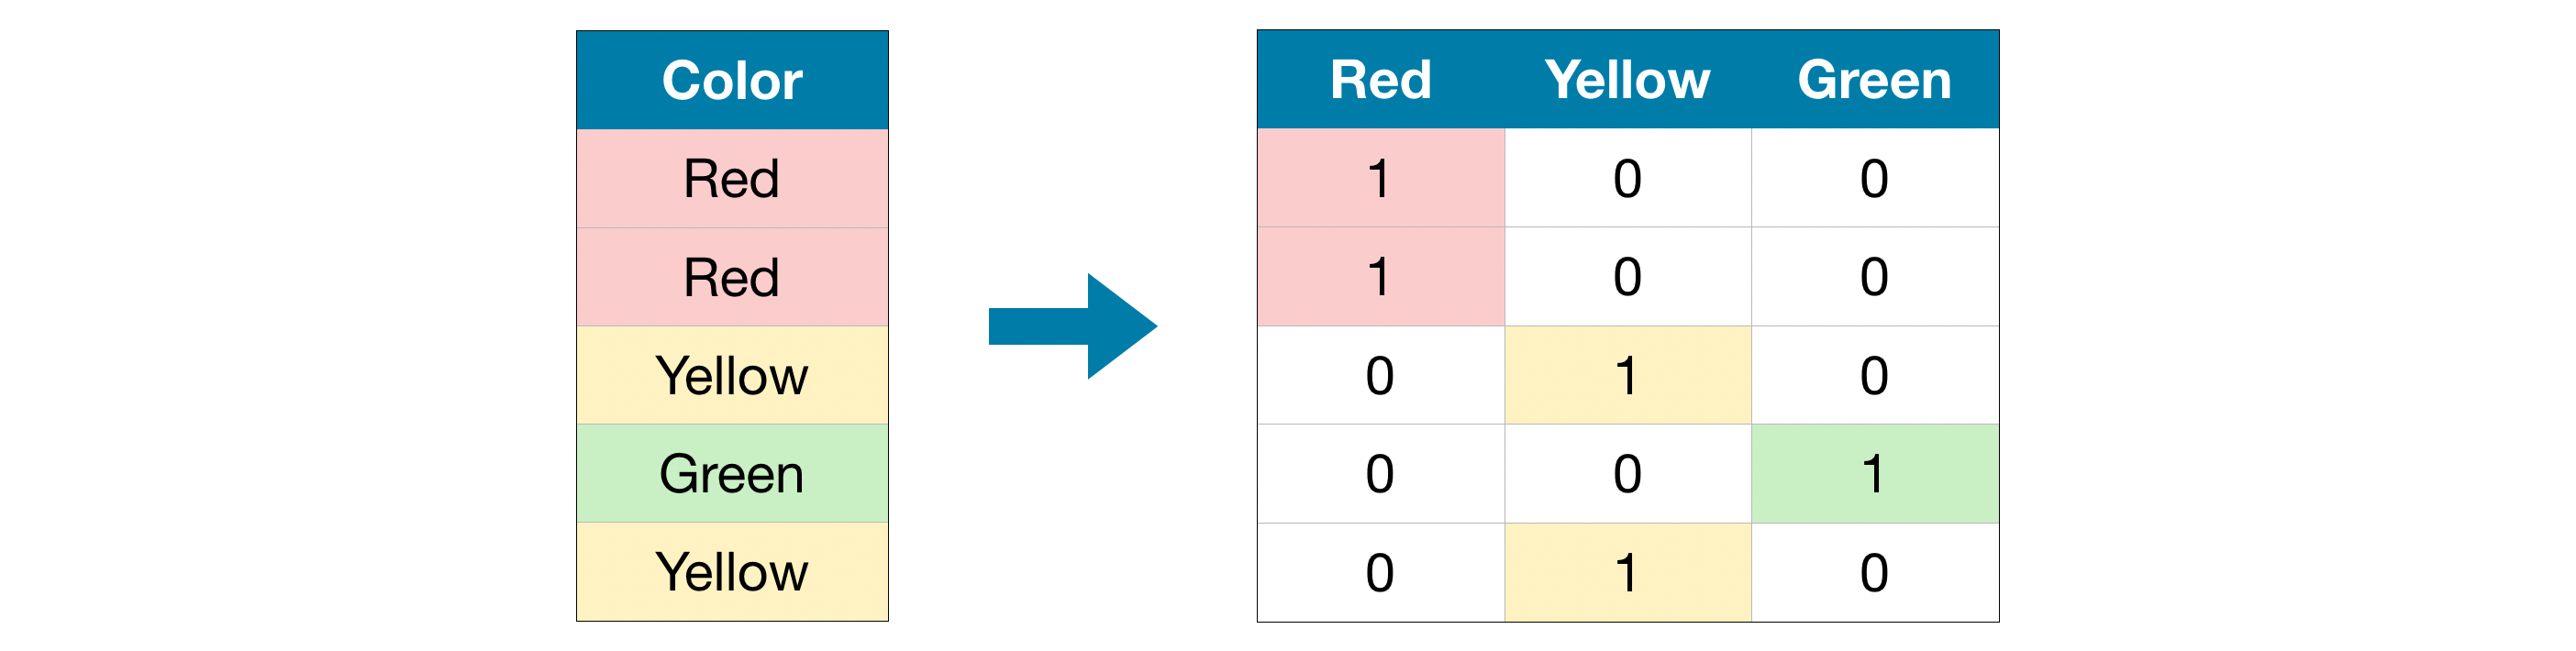

In the original dataset, "Color" is a categorical variable with three categories: "Red", "Yellow", and "Green". The corresponding one-hot encoding contains one column for each possible value, and one row for each row in the original dataset. Wherever the original value was "Red", we put a 1 in the "Red" column; if the original value was "Yellow", we put a 1 in the "Yellow" column, and so on.

In contrast to ordinal encoding, one-hot encoding does not assume an ordering of the categories. Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data (e.g., "Red" is neither more nor less than "Yellow"). We refer to categorical variables without an intrinsic ranking as nominal variables.

One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., you generally won't use it for variables taking more than 15 different values).

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('../data/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [44]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


In [45]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

Score from Approach 1 (Drop Categorical Values)

In [48]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
175703.48185157913


Score from Approach 2 (Ordinal Encoding)

Scikit-learn has a OrdinalEncoder class that can be used to get ordinal encodings. We loop over the categorical variables and apply the ordinal encoder separately to each column.

In [49]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
165936.40548390493


In the code cell above, for each column, we randomly assign each unique value to a different integer. This is a common approach that is simpler than providing custom labels; however, we can expect an additional boost in performance if we provide better-informed labels for all ordinal variables.

Score from Approach 3 (One-Hot Encoding)

We use the OneHotEncoder class from scikit-learn to get one-hot encodings. There are a number of parameters that can be used to customize its behavior.

- We set handle_unknown='ignore' to avoid errors when the validation data contains classes that aren't represented in the training data, and
- setting sparse=False ensures that the encoded columns are returned as a numpy array (instead of a sparse matrix).

To use the encoder, we supply only the categorical columns that we want to be one-hot encoded. For instance, to encode the training data, we supply X_train[object_cols]. (object_cols in the code cell below is a list of the column names with categorical data, and so X_train[object_cols] contains all of the categorical data in the training set.)

In [55]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

c:\Users\Mothling\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MAE from Approach 3 (One-Hot Encoding):
166089.4893009678


### Exercise

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('../data/intermediate_train.csv', index_col='Id')
X_test = pd.read_csv('../data/intermediate_test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [3]:
X_train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,RL,11694,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,108,0,0,260,0,0,7,2007,New,Partial
871,20,RL,6600,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,0,8,2009,WD,Normal
93,30,RL,13360,Pave,IR1,HLS,AllPub,Inside,Gtl,Crawfor,...,0,44,0,0,0,0,8,2009,WD,Normal
818,20,RL,13265,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,59,0,0,0,0,0,7,2008,WD,Normal
303,20,RL,13704,Pave,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,...,81,0,0,0,0,0,1,2006,WD,Normal


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

#### Step 1: Drop columns with categorical data

Dropping columns with categorical data

In [4]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
17837.82570776256


Checking the dataset further, looking at the Condition 2 column for both the training and validation data

In [5]:
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("\nUnique values in 'Condition2' column in validation data:", X_valid['Condition2'].unique())

Unique values in 'Condition2' column in training data: ['Norm' 'PosA' 'Feedr' 'PosN' 'Artery' 'RRAe']

Unique values in 'Condition2' column in validation data: ['Norm' 'RRAn' 'RRNn' 'Artery' 'Feedr' 'PosN']


#### Step 2: Ordinal encoding

##### Part A

If you now write code to:

- fit an ordinal encoder to the training data, and then
- use it to transform both the training and validation data,

you'll get an error. Can you see why this is the case?

In [7]:
from sklearn.preprocessing import OrdinalEncoder

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

Categorical variables:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


ValueError: Found unknown categories ['RRNn', 'RRAn'] in column 9 during transform

Fitting an ordinal encoder to a column in the training data creates a corresponding integer-valued label for each unique value that appears in the training data. In the case that the validation data contains values that don't also appear in the training data, the encoder will throw an error, because these values won't have an integer assigned to them. Notice that the 'Condition2' column in the validation data contains the values 'RRAn' and 'RRNn', but these don't appear in the training data -- thus, if we try to use an ordinal encoder with scikit-learn, the code will throw an error.

This is a common problem that you'll encounter with real-world data, and there are many approaches to fixing this issue. For instance, you can write a custom ordinal encoder to deal with new categories. The simplest approach, however, is to drop the problematic categorical columns.

Run the code cell below to save the problematic columns to a Python list bad_label_cols. Likewise, columns that can be safely ordinal encoded are stored in good_label_cols

In [8]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Functional', 'RoofMatl', 'Condition2']


##### Part B

Use the next code cell to ordinal encode the data in X_train and X_valid. Set the preprocessed DataFrames to label_X_train and label_X_valid, respectively.

- We have provided code below to drop the categorical columns in bad_label_cols from the dataset.
- You should ordinal encode the categorical columns in good_label_cols.

In [9]:
# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(X_valid[good_label_cols])

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
17098.01649543379


So far, you've tried two different approaches to dealing with categorical variables. And, you've seen that encoding categorical data yields better results than removing columns from the dataset.

Soon, you'll try one-hot encoding. Before then, there's one additional topic we need to cover. Begin by running the next code cell without changes.

In [10]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

#### Step 3: Investigating cardinality

##### Part A

The output above shows, for each column with categorical data, the number of unique values in the column. For instance, the 'Street' column in the training data has two unique values: 'Grvl' and 'Pave', corresponding to a gravel road and a paved road, respectively.

We refer to the number of unique entries of a categorical variable as the cardinality of that categorical variable. For instance, the 'Street' variable has cardinality 2.

##### Part B

For large datasets with many rows, one-hot encoding can greatly expand the size of the dataset. For this reason, we typically will only one-hot encode columns with relatively low cardinality. Then, high cardinality columns can either be dropped from the dataset, or we can use ordinal encoding.

Next, you'll experiment with one-hot encoding. But, instead of encoding all of the categorical variables in the dataset, you'll only create a one-hot encoding for columns with cardinality less than 10.

Run the code cell below without changes to set low_cardinality_cols to a Python list containing the columns that will be one-hot encoded. Likewise, high_cardinality_cols contains a list of categorical columns that will be dropped from the dataset.

In [13]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior2nd', 'Neighborhood', 'Exterior1st']


#### Step 4: One-hot encoding

Use the next code cell to one-hot encode the data in X_train and X_valid. Set the preprocessed DataFrames to OH_X_train and OH_X_valid, respectively.

- The full list of categorical columns in the dataset can be found in the Python list object_cols.
- You should only one-hot encode the categorical columns in low_cardinality_cols. All other categorical columns should be dropped from the dataset.

In [32]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

c:\Users\Mothling\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MAE from Approach 3 (One-Hot Encoding):
17525.345719178084


## Pipelines

### Introduction

Pipelines are a simple way to keep your data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step.

Many data scientists hack together models without pipelines, but pipelines have some important benefits. Those include:

1. Cleaner Code: Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
2. Fewer Bugs: There are fewer opportunities to misapply a step or forget a preprocessing step.
3. Easier to Productionize: It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.
4. More Options for Model Validation: You will see an example in the next tutorial, which covers cross-validation.

### Example

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('../data/melb_data.csv')

# Select target
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

We take a peek at the training data with the head() method below. Notice that the data contains both categorical data and columns with missing values. With a pipeline, it's easy to deal with both!

In [2]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,1.0,193.0,NaN,NaN,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,1.0,555.0,NaN,NaN,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,1.0,265.0,NaN,1995.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,2.0,673.0,673.0,1970.0,-37.76230,144.8272,4217.0


We construct the full pipeline in three steps.

Step 1: Define Preprocessing Steps
Similar to how a pipeline bundles together preprocessing and modeling steps, we use the ColumnTransformer class to bundle together different preprocessing steps. The code below:

- imputes missing values in numerical data, and
- imputes missing values and applies a one-hot encoding to categorical data.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Step 2: Define the Model

Next, we define a random forest model with the familiar RandomForestRegressor class.

In [4]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

Step 3: Create and Evaluate the Pipeline

Finally, we use the Pipeline class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:

- With the pipeline, we preprocess the training data and fit the model in a single line of code. (In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training in separate steps. This becomes especially messy if we have to deal with both numerical and categorical variables!)
- With the pipeline, we supply the unprocessed features in X_valid to the predict() command, and the pipeline automatically preprocesses the features before generating predictions. (However, without a pipeline, we have to remember to preprocess the validation data before making predictions.)

In [5]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 160679.18917034855


### Exercise

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('../data/intermediate_train.csv', index_col='Id')
X_test_full = pd.read_csv('../data/intermediate_test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [32]:
pd.set_option('display.max_rows', 60)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns

In [33]:
X_train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Ex,TA,PConc,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,New,Partial,20,90.0,11694,9,5,2007,2007,452.0,48,0,1774,1822,1828,0,0,1828,0,0,2,0,3,1,9,1,2007.0,3,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,1Fam,1Story,Hip,CompShg,NaN,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,N,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,60.0,6600,5,5,1962,1962,0.0,0,0,894,894,894,0,0,894,0,0,1,0,2,1,5,0,1962.0,1,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,NaN,TA,Gd,BrkTil,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,30,80.0,13360,5,7,1921,2006,0.0,713,0,163,876,964,0,0,964,1,0,1,0,2,1,5,0,1921.0,2,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,NaN,13265,8,5,2002,2002,148.0,1218,0,350,1568,1689,0,0,1689,1,0,2,0,3,1,7,2,2002.0,3,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,118.0,13704,7,5,2001,2002,150.0,0,0,1541,1541,1541,0,0,1541,0,0,2,0,3,1,6,1,2001.0,3,843,468,81,0,0,0,0,0,1,2006


In [34]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1168.000000,956.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1162.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1110.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.605308,69.614017,10589.672945,6.086473,5.572774,1970.890411,1984.692637,103.481067,439.890411,45.571918,568.049658,1053.511986,1160.958904,351.479452,6.444349,1518.882705,0.422089,0.054795,1.566781,0.384418,2.882705,1.044521,6.544521,0.612158,1978.140541,1.771404,473.632705,94.498288,48.044521,23.022260,3.218322,14.528253,2.118151,50.936644,6.301370,2007.819349
std,42.172322,22.946069,10704.180793,1.367472,1.116908,30.407486,20.684612,182.676225,435.106803,156.229962,437.569919,412.073393,373.315037,438.137938,51.200836,513.800708,0.514494,0.231409,0.546698,0.497118,0.802166,0.218441,1.624493,0.640872,24.877265,0.730041,209.442320,127.312017,68.619199,63.153093,27.916593,54.009608,36.482294,550.380636,2.725977,1.335971
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7589.500000,5.000000,5.000000,1953.750000,1966.000000,0.000000,0.000000,0.000000,228.000000,798.750000,884.000000,0.000000,0.000000,1139.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9512.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,379.500000,0.000000,482.500000,992.000000,1092.000000,0.000000,0.000000,1471.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,477.500000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,167.750000,716.000000,0.000000,811.250000,1276.250000,1389.250000,729.000000,0.000000,1788.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1120.000000,2153.000000,3206.000000,3228.000000,1872.000000,572.000000,4676.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1390.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [35]:
X_train

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Ex,TA,PConc,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,New,Partial,20,90.0,11694,9,5,2007,2007,452.0,48,0,1774,1822,1828,0,0,1828,0,0,2,0,3,1,9,1,2007.0,3,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,1Fam,1Story,Hip,CompShg,NaN,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,N,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,60.0,6600,5,5,1962,1962,0.0,0,0,894,894,894,0,0,894,0,0,1,0,2,1,5,0,1962.0,1,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,NaN,TA,Gd,BrkTil,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,30,80.0,13360,5,7,1921,2006,0.0,713,0,163,876,964,0,0,964,1,0,1,0,2,1,5,0,1921.0,2,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,NaN,13265,8,5,2002,2002,148.0,1218,0,350,1568,1689,0,0,1689,1,0,2,0,3,1,7,2,2002.0,3,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,118.0,13704,7,5,2001,2002,150.0,0,0,1541,1541,1541,0,0,1541,0,0,2,0,3,1,6,1,2001.0,3,843,468,81,0,0,0,0,0,1,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,Gable,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60,82.0,9430,8,5,1999,1999,673.0,1163,0,89,1252,1268,1097,0,2365,1,0,2,1,3,1,8,1,1999.0,3,856,0,128,0,0,180,0,0,7,2009
836,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,NaN,TA,TA,CBlock,Gd,TA,No,BLQ,Unf,GasA,TA,Y,SBrkr,Gd,Min2,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,60.0,9600,4,7,1950,1995,0.0,442,0,625,1067,1067,0,0,1067,0,0,2,0,2,1,4,0,1996.0,2,436,290,0,0,0,0,0,0,2,2010
1217,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,RRAe,Norm,Duplex,1.5Fin,Gable,CompShg,NaN,TA,TA,Slab,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,SBrkr,TA,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,90,68.0,8930,6,5,1978,1978,0.0,0,0,0,0,1318,584,0,1902,0,0,2,0,4,2,8,0,1978.0,2,539,0,0,0,0,0,0,0,4,2010


Preprocessing the data and training

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17614.81993150685


#### Step 1: Improve the performance

##### Part A

In the code cell below, define your own preprocessing steps and random forest model. Fill in values for the following variables:

- numerical_transformer
- categorical_transformer
- model

To pass this part of the exercise, you need only define valid preprocessing steps and a random forest model.

##### Checking the data

In [80]:
# Getting names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Getting number of columns with missing values
num_miss_cols = len(cols_with_missing)

# Getting the missing value count by columns
missing_val_count_by_column = (X_train.isnull().sum())

# Getting numerical missing value count by columns
numerical_miss_cols = X_train.select_dtypes(include=['number']).columns
missing_val_count_by_column_num = (X_train[numerical_miss_cols].isnull().sum())

# Getting categorical missing value count by columns
categorical_miss_cols = X_train.select_dtypes(exclude=['number']).columns
missing_val_count_by_column_cat = (X_train[categorical_miss_cols].isnull().sum())

print("""Number of missing columns: {}
      \nColumns with missing values:\n{}
      \nMissing value count by column:
      Numerical\n{}
      Categorical\n{}""".format(num_miss_cols, cols_with_missing, missing_val_count_by_column_num[missing_val_count_by_column_num > 0].to_string(), missing_val_count_by_column_cat[missing_val_count_by_column_cat > 0].to_string()))

Number of missing columns: 19
      
Columns with missing values:
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt']
      
Missing value count by column:
      Numerical
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
      Categorical
Alley           1097
MasVnrType       707
BsmtQual          28
BsmtCond          28
BsmtExposure      28
BsmtFinType1      28
BsmtFinType2      29
Electrical         1
FireplaceQu      551
GarageType        58
GarageFinish      58
GarageQual        58
GarageCond        58
PoolQC          1164
Fence            954
MiscFeature     1119


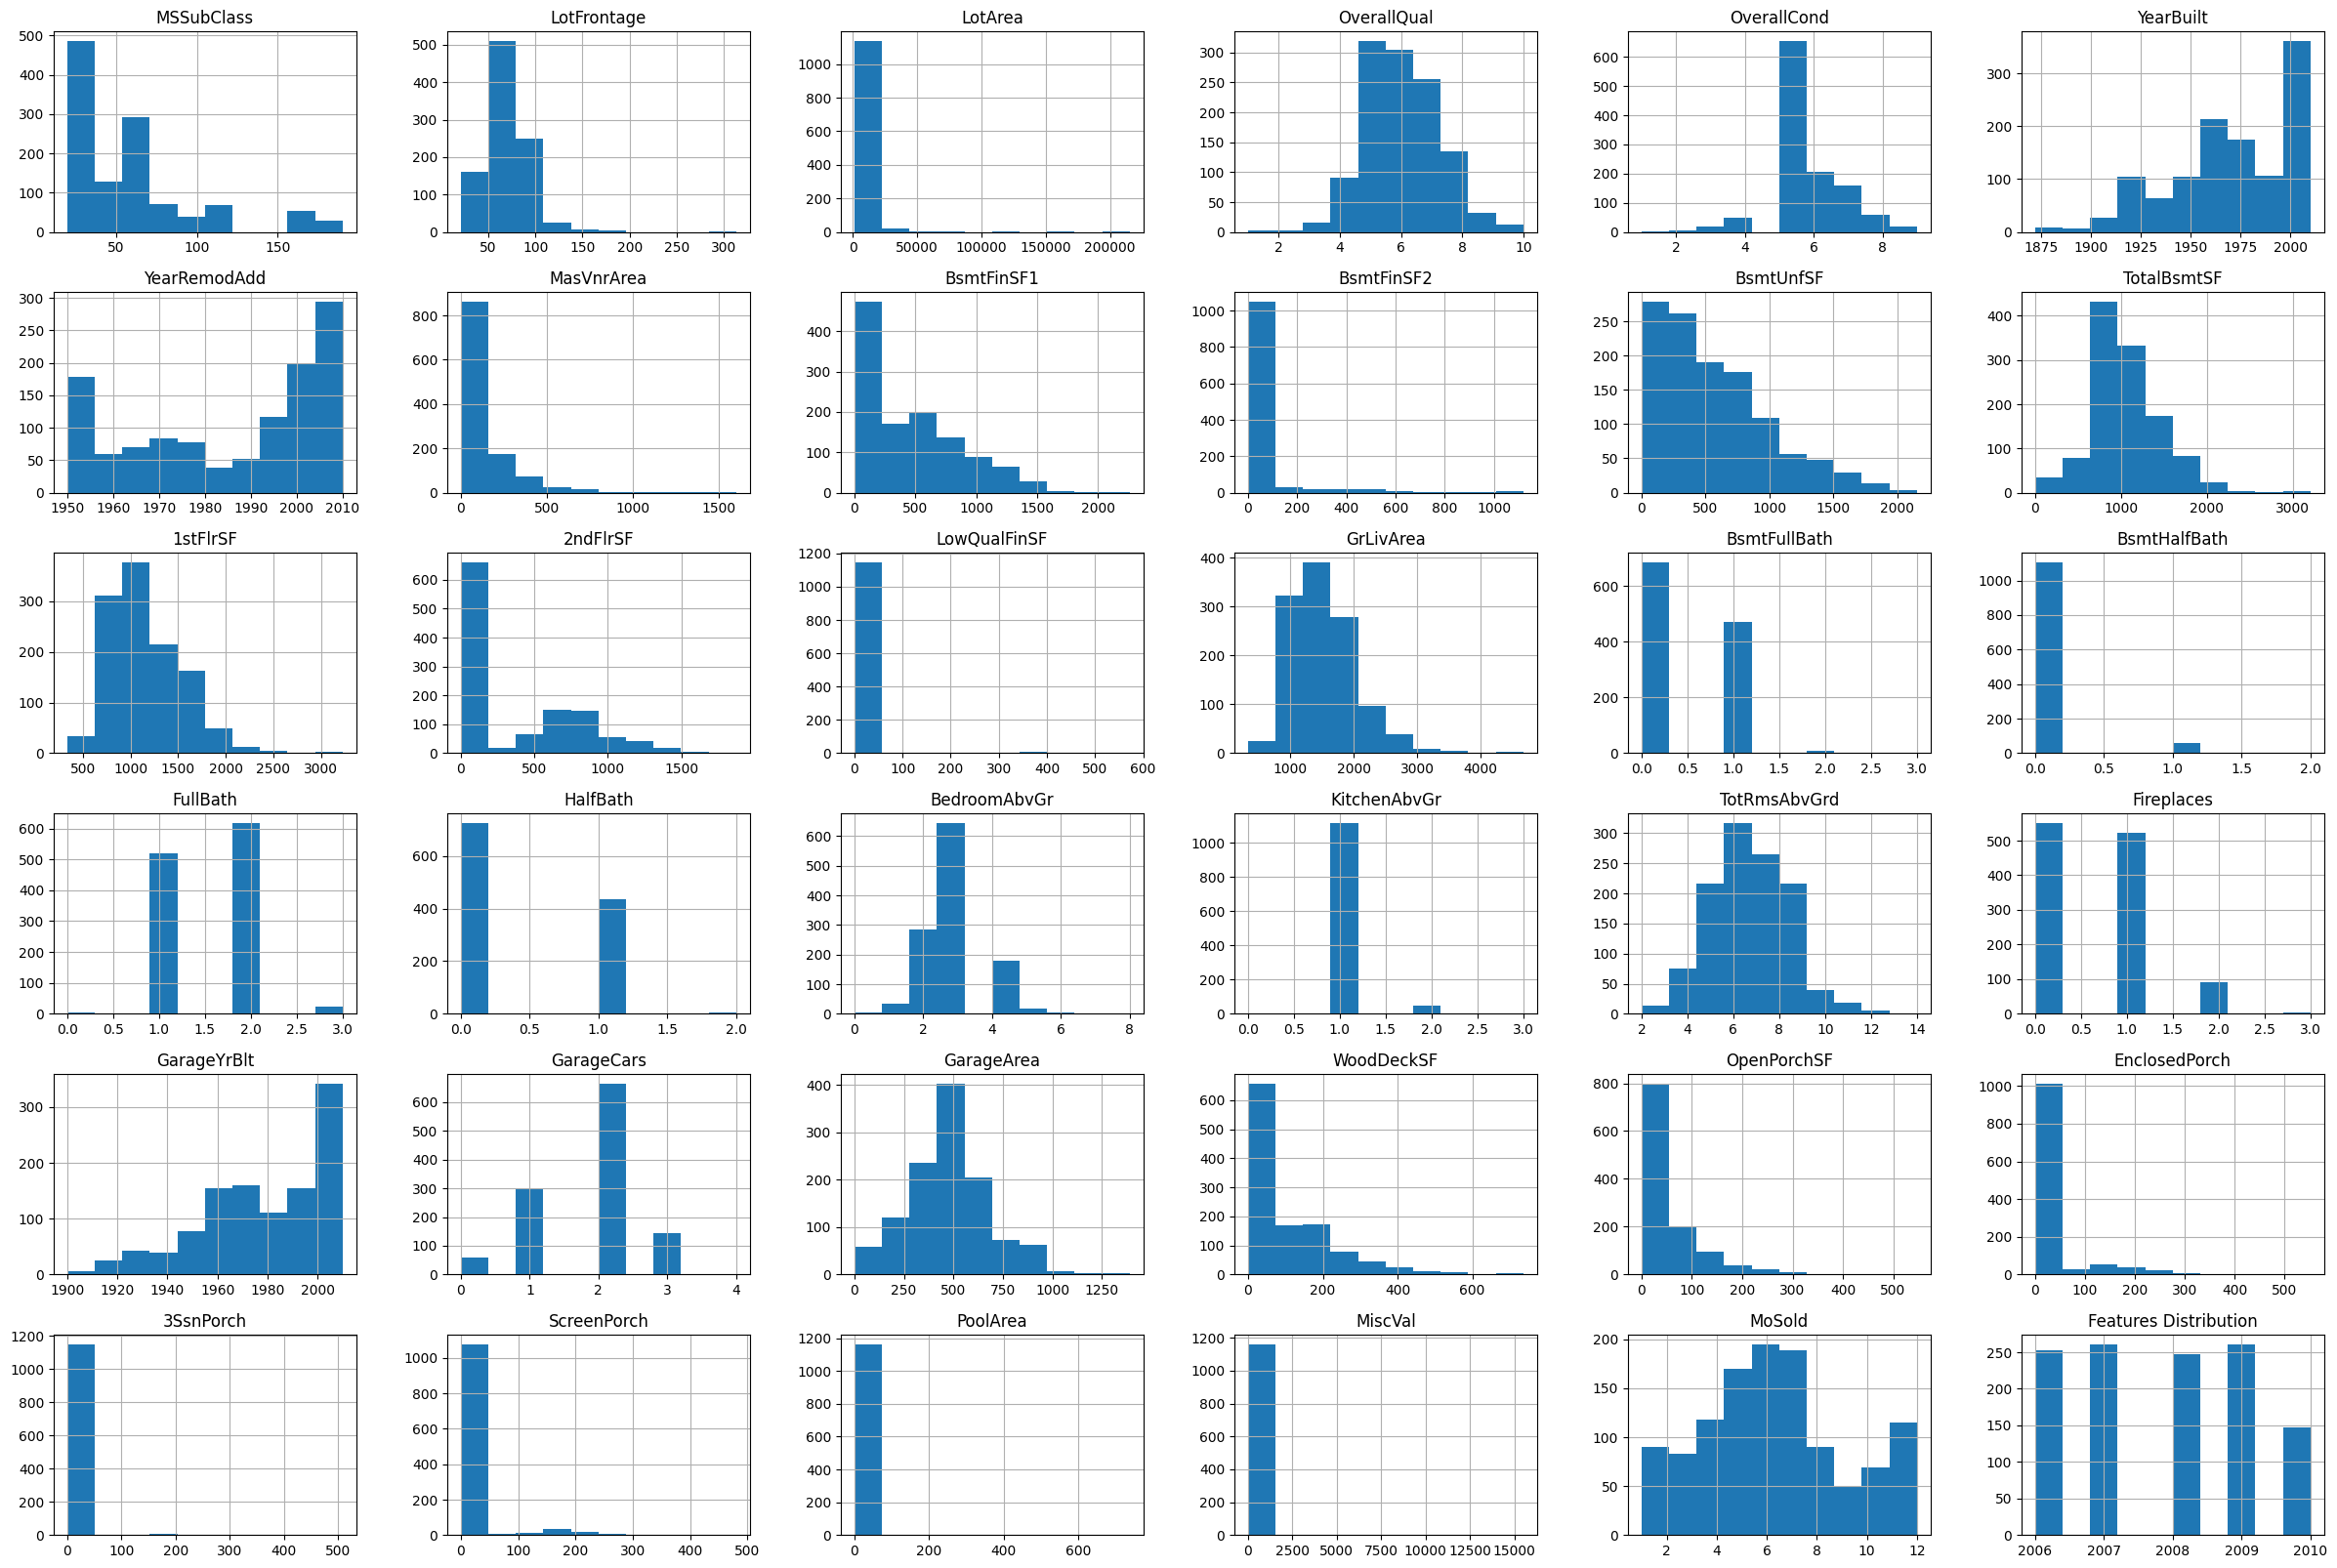

In [37]:
import matplotlib.pyplot as plt

# Check the distribution of all the features
X_train.hist(figsize=(30,20))
plt.title("Features Distribution")
plt.show()

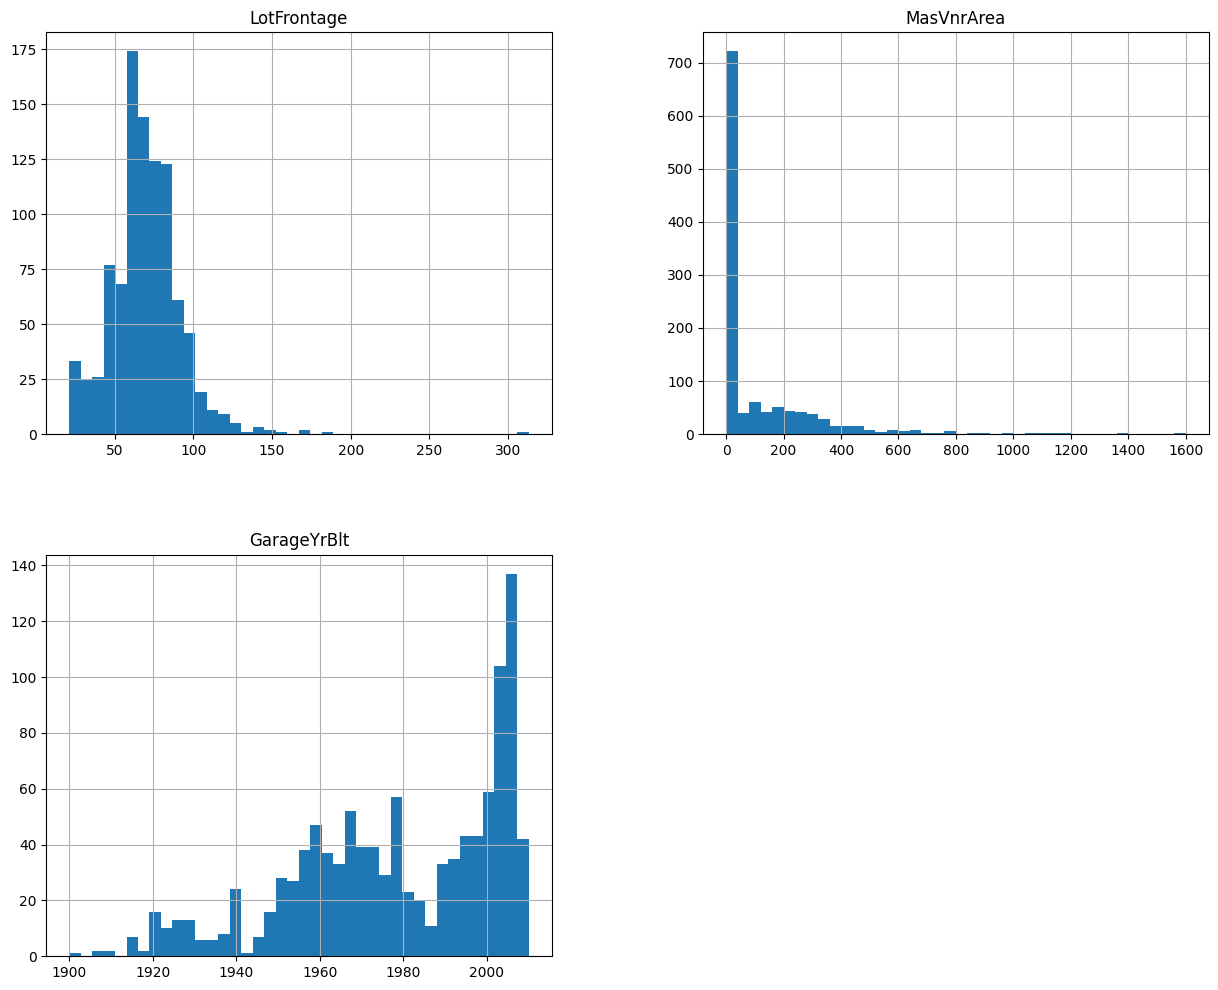

In [85]:
# Check the distribution of all the features
X_train[cols_with_missing].hist(figsize=(15,12), bins=40)
plt.title("Features Distribution")
plt.show()

##### Continuing

In [ ]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean') # Your code here

# Preprocessing for categorical data
categorical_transformer = ____ # Your code here

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = ____ # Your code here